In [27]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [28]:
data = np.loadtxt(
    '3wavelengths_try1.dat',
    skiprows=1,
    delimiter=','
)

In [29]:
phoh, od_380, od_400, od_365 = data.T

### Outline of problem

lol we didnt outline the problem. 



In [30]:
con_N0 = 7.5 * 1e-6
eps_N_380 = od_380[0] / con_N0 
con_X = phoh

def con_NX(K1, K2):
    
    con = (
        K1 * con_N0 * con_X
        )/(
        1 + K1*con_X + K1*K2*con_X**2.
        )
    
    return con

def con_NX2(K1, K2):
    
    con = con_NX(K1, K2) * K2 * con_X
    
    return con
    

In [33]:
eps_N_380

26759.611085404536

In [34]:
def con_N(K1, K2):
    
    con = con_N0 - con_NX(K1, K2) - con_NX2(K1, K2)
    
    return con

In [35]:
np.hstack((con_N(1,1),con_N(1,1)))

array([7.50000000e-06, 7.27741843e-06, 7.06026059e-06, 6.84922958e-06,
       6.64482307e-06, 6.44736842e-06, 6.25705376e-06, 6.07395487e-06,
       5.89805825e-06, 5.72928052e-06, 5.56748466e-06, 5.19230769e-06,
       4.82728363e-06, 4.49437785e-06, 4.19148836e-06, 3.91623946e-06,
       3.66618721e-06, 3.43894644e-06, 3.23226398e-06, 3.04405630e-06,
       2.87242426e-06, 7.50000000e-06, 7.27741843e-06, 7.06026059e-06,
       6.84922958e-06, 6.64482307e-06, 6.44736842e-06, 6.25705376e-06,
       6.07395487e-06, 5.89805825e-06, 5.72928052e-06, 5.56748466e-06,
       5.19230769e-06, 4.82728363e-06, 4.49437785e-06, 4.19148836e-06,
       3.91623946e-06, 3.66618721e-06, 3.43894644e-06, 3.23226398e-06,
       3.04405630e-06, 2.87242426e-06])

In [36]:
def em_fun_at_380(unknowns):
    """ System of equations """
    K1, K2 = unknowns[:2]
    eps_NX = unknowns[2]#*1e5
    eps_NX2 = unknowns[3]#*1e4
    
    f = (
        eps_N * con_N(K1, K2)
        + 
        eps_NX * con_NX(K1, K2) 
        +
        eps_NX2 * con_NX2(K1, K2)
        ) - od_380
    
    return f

In [37]:
def d_NX_d_K1(K1, K2):
    
    first_term = (
        con_N0 * con_X 
        * 
        (1 + K1*con_X + K1*K2*con_X**2.)**(-1.)
        )
    
    second_term = (
        K1 * con_N0 * con_X 
        *
        (-1)*(1 + K1*con_X + K1*K2*con_X**2.)**(-2.)
        *
        (con_X + K2*con_X**2.)
        )
    
    return first_term + second_term


def d_NX2_d_K1(K1, K2):
    
    return con_X * K2 * d_NX_d_K1(K1, K2) 


def d_NX_d_K2(K1, K2):
    
    der = (
        K1*con_N0*con_X
        *
        (-1)*(1 + K1*con_X + K1*K2*con_X**2.)**(-2.)
        *
        K1*con_X**2.
        )
    
    return der


def d_NX2_d_K2(K1, K2):
    
    der = con_X * (
        con_NX(K1, K2) 
        + 
        K2 * d_NX_d_K2(K1, K2)
        )
    
    return der


def d_N_d_K1(K1, K2):
    
    return -d_NX_d_K1(K1, K2) - d_NX2_d_K1(K1, K2)
    
    
def d_N_d_K2(K1, K2):
    
    return -d_NX_d_K2(K1, K2) - d_NX2_d_K2(K1, K2)


def jaco(unknowns):
    
    K1, K2 = unknowns[:2]
    eps_NX = unknowns[2]#*1e5
    eps_NX2 = unknowns[3]#*1e4
    
    ## Take derivitives with respect to K1
    ddk1 = (
        eps_N*d_N_d_K1(K1, K2)
        +
        eps_NX*d_NX_d_K1(K1, K2)
        +
        eps_NX2*d_NX2_d_K1(K1, K2)
        )
    
    ddk2 = (
        eps_N*d_N_d_K2(K1, K2)
        +
        eps_NX*d_NX_d_K2(K1, K2)
        +
        eps_NX2*d_NX2_d_K2(K1, K2)
        )
    
    ddepsNX = con_NX(K1, K2)
    
    ddepsNX2 = con_NX2(K1, K2)
    
    j = np.vstack((ddk1, ddk2, ddepsNX, ddepsNX2))
    
    return j.T

In [38]:
jaco([1, 1, 1, 1])

NameError: name 'eps_N' is not defined

In [ ]:
np.linalg.matrix_rank(jaco([1,1,1,1]))

In [ ]:
em_fun_at_380([1, 2, 3, 4])

In [ ]:
from scipy.optimize import Bounds

In [ ]:
# ini_guess = [41.5, .06, 1.1, .25]
ini_guess = [6.03599333e+00, 4.61655475e-01, 1.42647085e+00, 1]

# sol = opt.root(
#     em_fun_at_380, 
#     ini_guess, 
# #     jac=jaco, 
#     method='lm',
# #     bounds=Bounds([0], [np.inf])
# )

sol = opt.least_squares(
    em_fun_at_380, 
    ini_guess, 
#     jac=jaco, 
#     method='lm',
    bounds=(0, np.inf),
    x_scale='jac'
)


In [ ]:
sol.success

In [ ]:
sol

In [ ]:
def Absorbance_380(params):
    
    return em_fun_at_380(params)+od_380

In [ ]:

## Plot initial guess
plt.plot(
    con_X, 
    Absorbance_380(ini_guess), 
    ls='--',
    c='k',
    label='initial guess')

plt.plot(con_X, Absorbance_380(sol.x), label='result!?!?!')

plt.xlabel('[X]')
plt.ylabel('OD')
plt.scatter(con_X, od_380, c='C1')
plt.title('380 nm')
plt.legend()


In [ ]:
fit_params = sol.x

### Try with Jacobian

In [ ]:
# ini_guess = [41.5, .06, 1.1, .25]
ini_guess = [6.03599333e+00, 4.61655475e-01, 1.42647085e+00, 1]

sol_jac = opt.least_squares(
    em_fun_at_380, 
    ini_guess, 
    jac=jaco, 
#     method='lm',
    bounds=(0, np.inf),
    x_scale='jac'
)


In [ ]:
sol_jac

In [32]:
## Compare computed Jacobian at solution to analytic 
(sol.jac - jaco(sol.x))/(sol.jac)

NameError: name 'sol' is not defined

In [ ]:
## Compare resulting parameters
(sol.x - sol_jac.x)/sol.x

In [ ]:
sol.x

In [ ]:
sol_jac.x

# Multi wavelength...

In [39]:
## get eps_N for each wavelength 
eps_N_vec = np.array([od[0] for od in data.T[1:]])/con_N0

In [63]:

def em_fit_fun(unknowns):
    """ System of equations """
    K1, K2 = unknowns[:2]
    ## Check the length of eps_N_vec
        ## 2 * len(eps_N_vec) more unknowns
    
    ## Iterate through eps_N for each wavelength
    for i, eps_N in enumerate(eps_N_vec):
    
        ## Grab other two eps's from unknown arg (vector/list)
        ## eps_NX are odd indexed
        eps_NX = unknowns[2*(i+1)]
        ## eps_NX2s are even indexed
        eps_NX2 = unknowns[2*(i+1)+1]
        
        ## Build cost function for this wavelength 
        f = (
            eps_N * con_N(K1, K2)
            + 
            eps_NX * con_NX(K1, K2) 
            +
            eps_NX2 * con_NX2(K1, K2)
            ) - data.T[i+1]
        
        ## add value of cost funtion to list
        if i is 0:
            f_tot = f
        elif i is not 0:
            f_tot = np.hstack((f_tot, f))

    return f_tot

In [42]:
# ini_guess = [41.5, .06, 1.1, .25]
ini_guess_multi = [6.03599333e+00, 4.61655475e-01, 1.42647085e+00, 1,1.42647085e+00, 1,1.42647085e+00, 1]

# sol = opt.root(
#     em_fun_at_380, 
#     ini_guess, 
# #     jac=jaco, 
#     method='lm',
# #     bounds=Bounds([0], [np.inf])
# )

fit_multi = opt.least_squares(
    em_fit_fun, 
    ini_guess_multi, 
#     jac=jaco, 
#     method='lm',
    bounds=(0, np.inf),
    x_scale='jac'
)


In [43]:
fit_multi

 active_mask: array([0, 0, 0, 0, 0, 0, 0, 0])
        cost: 0.0004066523983596253
         fun: array([ 0.00000000e+00, -7.52180703e-03, -5.66519140e-03, -1.71619859e-03,
        3.92440955e-03,  5.19447156e-03,  5.15805189e-03,  4.15430068e-03,
        2.22266769e-03,  1.14064149e-03, -1.28090229e-03, -8.05969189e-03,
       -4.10707341e-03, -2.30269602e-03, -8.32491468e-04,  3.34170481e-04,
       -4.23216389e-04,  1.12112286e-03,  1.53061505e-03,  1.13473925e-03,
        9.24492496e-04,  0.00000000e+00,  2.94721705e-03,  4.14564192e-03,
        4.54953660e-03,  4.87991982e-03,  4.39369833e-03,  3.38646691e-03,
        2.14911121e-03,  7.07498023e-04, -5.88596179e-04, -1.92083074e-03,
       -5.54935616e-03, -6.05992392e-03, -6.08543617e-03, -5.26501945e-03,
       -3.90565312e-03, -2.14881239e-03, -7.21622961e-05,  1.80256199e-03,
        5.10368956e-03,  8.31590714e-03,  0.00000000e+00,  1.98625143e-03,
        4.04851758e-03,  4.71944401e-03,  3.42866078e-03,  2.82317773e-03,
    

In [44]:
eps_N_vec.shape[0]

3

In [45]:
data.T[1:].shape

(3, 21)

In [46]:
def Absorbance_per_wavelength(params):
    
    n_wavelengths = eps_N_vec.shape[0]
    
    ## em_fit_fun is length = n_wavelengths * 21
    
    em_fit_array = em_fit_fun(params).reshape((n_wavelengths, 21))
    
    absorb = em_fit_array + data.T[1:]
    
    return absorb

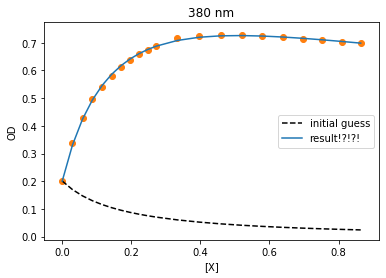

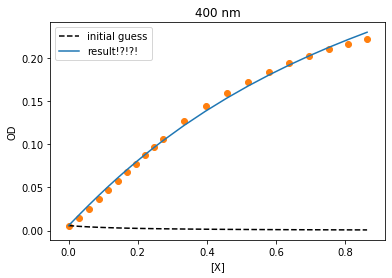

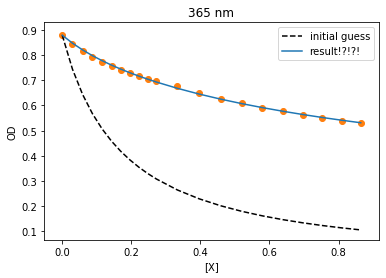

In [47]:


## Plot initial guess
plt.plot(
    con_X, 
    Absorbance_per_wavelength(ini_guess_multi)[0], 
    ls='--',
    c='k',
    label='initial guess')

plt.plot(con_X, Absorbance_per_wavelength(fit_multi.x)[0], label='result!?!?!')

plt.xlabel('[X]')
plt.ylabel('OD')
plt.scatter(con_X, od_380, c='C1')
plt.title('380 nm')
plt.legend()

plt.figure()
## Plot initial guess
plt.plot(
    con_X, 
    Absorbance_per_wavelength(ini_guess_multi)[1], 
    ls='--',
    c='k',
    label='initial guess')

plt.plot(con_X, Absorbance_per_wavelength(fit_multi.x)[1], label='result!?!?!')

plt.xlabel('[X]')
plt.ylabel('OD')
plt.scatter(con_X, od_400, c='C1')
plt.title('400 nm')
plt.legend()

plt.figure()
## Plot initial guess
plt.plot(
    con_X, 
    Absorbance_per_wavelength(ini_guess_multi)[2], 
    ls='--',
    c='k',
    label='initial guess')

plt.plot(con_X, Absorbance_per_wavelength(fit_multi.x)[2], label='result!?!?!')

plt.xlabel('[X]')
plt.ylabel('OD')
plt.scatter(con_X, od_365, c='C1')
plt.title('365 nm')
plt.legend()


#### Fitting all wavelengths 
---
First load datas

In [48]:
with open('all_wavelengths_PhOH.dat') as file:
    for i in range(5):
        print(file.readline())

--	550	549.5	549	548.5	548	547.5	547	546.5	546	545.5	545	544.5	544	543.5	543	542.5	542	541.5	541	540.5	540	539.5	539	538.5	538	537.5	537	536.5	536	535.5	535	534.5	534	533.5	533	532.5	532	531.5	531	530.5	530	529.5	529	528.5	528	527.5	527	526.5	526	525.5	525	524.5	524	523.5	523	522.5	522	521.5	521	520.5	520	519.5	519	518.5	518	517.5	517	516.5	516	515.5	515	514.5	514	513.5	513	512.5	512	511.5	511	510.5	510	509.5	509	508.5	508	507.5	507	506.5	506	505.5	505	504.5	504	503.5	503	502.5	502	501.5	501	500.5	500	499.5	499	498.5	498	497.5	497	496.5	496	495.5	495	494.5	494	493.5	493	492.5	492	491.5	491	490.5	490	489.5	489	488.5	488	487.5	487	486.5	486	485.5	485	484.5	484	483.5	483	482.5	482	481.5	481	480.5	480	479.5	479	478.5	478	477.5	477	476.5	476	475.5	475	474.5	474	473.5	473	472.5	472	471.5	471	470.5	470	469.5	469	468.5	468	467.5	467	466.5	466	465.5	465	464.5	464	463.5	463	462.5	462	461.5	461	460.5	460	459.5	459	458.5	458	457.5	457	456.5	456	455.5	455	454.5	454	453.5	453	452.5	452	451.5	451	450

In [49]:
all_wavelengths = np.loadtxt(
    'all_wavelengths_PhOH.dat',
#     skiprows=1,
    usecols=range(1,502),
    delimiter='\t'
    )[0]

In [50]:
all_wavelengths.shape

(501,)

In [51]:
all_wavelengths

array([550. , 549.5, 549. , 548.5, 548. , 547.5, 547. , 546.5, 546. ,
       545.5, 545. , 544.5, 544. , 543.5, 543. , 542.5, 542. , 541.5,
       541. , 540.5, 540. , 539.5, 539. , 538.5, 538. , 537.5, 537. ,
       536.5, 536. , 535.5, 535. , 534.5, 534. , 533.5, 533. , 532.5,
       532. , 531.5, 531. , 530.5, 530. , 529.5, 529. , 528.5, 528. ,
       527.5, 527. , 526.5, 526. , 525.5, 525. , 524.5, 524. , 523.5,
       523. , 522.5, 522. , 521.5, 521. , 520.5, 520. , 519.5, 519. ,
       518.5, 518. , 517.5, 517. , 516.5, 516. , 515.5, 515. , 514.5,
       514. , 513.5, 513. , 512.5, 512. , 511.5, 511. , 510.5, 510. ,
       509.5, 509. , 508.5, 508. , 507.5, 507. , 506.5, 506. , 505.5,
       505. , 504.5, 504. , 503.5, 503. , 502.5, 502. , 501.5, 501. ,
       500.5, 500. , 499.5, 499. , 498.5, 498. , 497.5, 497. , 496.5,
       496. , 495.5, 495. , 494.5, 494. , 493.5, 493. , 492.5, 492. ,
       491.5, 491. , 490.5, 490. , 489.5, 489. , 488.5, 488. , 487.5,
       487. , 486.5,

In [52]:
all_data = np.loadtxt(
    'all_wavelengths_PhOH.dat',
    skiprows=1,
    delimiter='\t'
)

In [58]:
all_data.T

array([[ 0.00000000e+00,  2.97029703e-02,  5.88235294e-02, ...,
         7.53138075e-01,  8.09128631e-01,  8.64197531e-01],
       [ 5.09473912e-05,  1.28385040e-04,  1.34041765e-06, ...,
        -1.28252675e-04, -9.30530609e-06, -1.88152134e-04],
       [ 9.00559181e-05,  4.14215772e-05,  9.42807806e-05, ...,
        -1.13488749e-05,  4.23777600e-05, -1.21378721e-04],
       ...,
       [ 2.41433077e-01,  2.54851678e-01,  2.63722029e-01, ...,
         3.12223940e-01,  3.13151751e-01,  3.14673409e-01],
       [ 2.42907001e-01,  2.56002706e-01,  2.64609120e-01, ...,
         3.16729961e-01,  3.18141074e-01,  3.20313657e-01],
       [ 2.44336927e-01,  2.57085562e-01,  2.65374836e-01, ...,
         3.22995257e-01,  3.24975605e-01,  3.27460276e-01]])

Let's trim the data a bit

In [82]:
max_wavelength = np.argwhere(all_wavelengths == 470)[0,0]
min_wavelength = np.argwhere(all_wavelengths == 320)[0,0]

In [70]:
all_data

array([[ 0.00000000e+00,  5.09473912e-05,  9.00559181e-05, ...,
         2.41433077e-01,  2.42907001e-01,  2.44336927e-01],
       [ 2.97029703e-02,  1.28385040e-04,  4.14215772e-05, ...,
         2.54851678e-01,  2.56002706e-01,  2.57085562e-01],
       [ 5.88235294e-02,  1.34041765e-06,  9.42807806e-05, ...,
         2.63722029e-01,  2.64609120e-01,  2.65374836e-01],
       ...,
       [ 7.53138075e-01, -1.28252675e-04, -1.13488749e-05, ...,
         3.12223940e-01,  3.16729961e-01,  3.22995257e-01],
       [ 8.09128631e-01, -9.30530609e-06,  4.23777600e-05, ...,
         3.13151751e-01,  3.18141074e-01,  3.24975605e-01],
       [ 8.64197531e-01, -1.88152134e-04, -1.21378721e-04, ...,
         3.14673409e-01,  3.20313657e-01,  3.27460276e-01]])

In [83]:
max_wavelength

160

In [84]:
trimmed_data = all_data[:, max_wavelength:min_wavelength]

In [85]:
trimmed_data.shape

(21, 300)

In [89]:
extra_trimmed_data = trimmed_data[:, range(0, 300, 2)]

In [100]:
extra_trimmed_data.shape

(21, 150)

Create vector of $\epsilon_N$ for every wavelength. 

(I am risking resusing variable names from the 3 wavelength example above...)

In [91]:
def get_eps_N_per_wavelength(data):
    return np.array([od[0] for od in data.T[1:]])/con_N0

In [101]:
test_data = extra_trimmed_data[:,70:90]

In [102]:
eps_N_vec = get_eps_N_per_wavelength(test_data)

In [103]:
eps_N_vec.shape

(19,)

Want: 
| $\lambda$ | eps_NX | eps_NX2|
|     --      |  --      |  --      |

## Try the BIG FIT

In [118]:
## add data as arg to fit function

def em_fit_fun(unknowns, *args):
    """ System of equations """
    K1, K2 = unknowns[:2]
    ## Check the length of eps_N_vec
        ## 2 * len(eps_N_vec) more unknowns
        
    ## Get data from args tuple
    data = args[0]
    eps_N_vec = args[1]
    
    ## Iterate through eps_N for each wavelength
    for i, eps_N in enumerate(eps_N_vec):
    
        ## Grab other two eps's from unknown arg (vector/list)
        ## eps_NX are odd indexed
        eps_NX = unknowns[2*(i+1)]
        ## eps_NX2s are even indexed
        eps_NX2 = unknowns[2*(i+1)+1]
        
        ## Build cost function for this wavelength 
        f = (
            eps_N * con_N(K1, K2)
            + 
            eps_NX * con_NX(K1, K2) 
            +
            eps_NX2 * con_NX2(K1, K2)
            ) - data.T[i+1]
        
        ## add value of cost funtion to list
        if i is 0:
            f_tot = f
        elif i is not 0:
            f_tot = np.hstack((f_tot, f))

    return f_tot

In [116]:
dummy_ini_guesses = [6.03599333e+00, 4.61655475e-01] + [1*1e4, 1*1e5]*19

In [117]:
# ini_guess = [41.5, .06, 1.1, .25]
# ini_guess_multi = [6.03599333e+00, 4.61655475e-01, 1.42647085e+00, 1,1.42647085e+00, 1,1.42647085e+00, 1]

# sol = opt.root(
#     em_fun_at_380, 
#     ini_guess, 
# #     jac=jaco, 
#     method='lm',
# #     bounds=Bounds([0], [np.inf])
# )

fit_multi = opt.least_squares(
    em_fit_fun, 
    dummy_ini_guesses, 
#     jac=jaco, 
#     method='lm',
    args=(test_data, eps_N_vec),
    bounds=(0, np.inf),
    x_scale='jac'
)


TypeError: em_fit_fun() takes 2 positional arguments but 3 were given

In [108]:
fit_multi

 active_mask: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        cost: 0.002839429132080021
         fun: array([ 0.00000000e+00, -2.35644202e-03, -3.25434370e-03, -2.92993048e-03,
       -1.57679331e-03, -2.91218584e-04,  5.11688261e-04,  1.16080559e-03,
        1.29661117e-03,  1.62515221e-03,  1.56348643e-03,  5.43265135e-05,
        6.05697013e-04,  5.39311973e-04,  3.63731894e-04,  1.89290468e-04,
       -2.13225570e-04, -4.53035882e-04, -1.30466978e-03, -6.20345311e-04,
       -2.42847694e-04,  0.00000000e+00, -2.16183306e-03, -3.03940738e-03,
       -2.67698192e-03, -1.26438490e-03, -1.78263787e-05,  7.46718560e-04,
        1.36636712e-03,  1.37297401e-03,  1.63818975e-03,  1.42820685e-03,
       -3.44922967e-04,  1.15441883e-04,  4.34670221e-05, -5.99398933e-05,
       -9.14154860e-05, -3.23764295e-04, -4.86786175e-04, -1.00109881e-03,
       -2.51771934e-04,  4.15598641e-04,  0.00000000

In [121]:
def Absorbance_per_wavelength(params, *args):
    
    ## get vec of eps_N from args to count wavelengths
    eps_N_vec = args[1]
    n_wavelengths = eps_N_vec.shape[0]
    ## get data 
    data = args[0]
    
    ## em_fit_fun is length = n_wavelengths * 21
    
    em_fit_array = em_fit_fun(params, *args).reshape((n_wavelengths, 21))
    
    absorb = em_fit_array + data.T[1:]
    
    return absorb

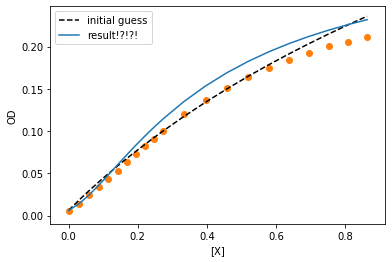

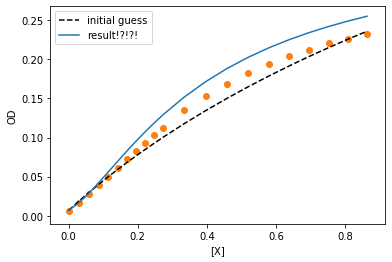

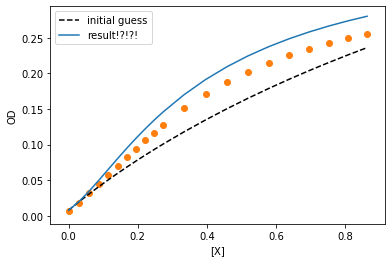

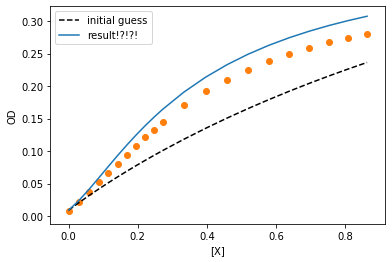

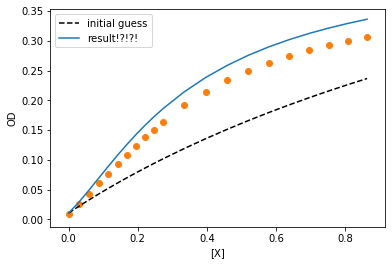

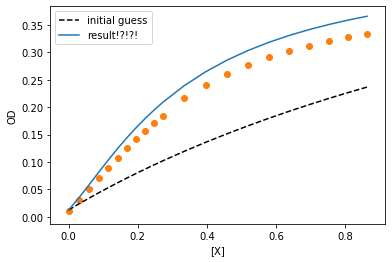

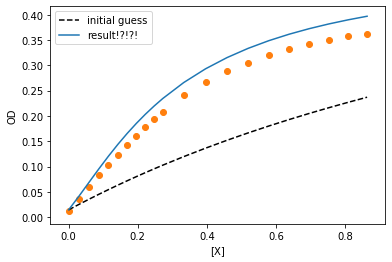

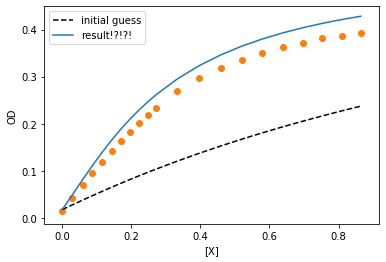

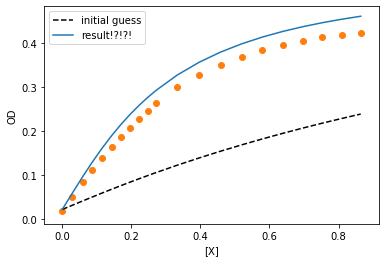

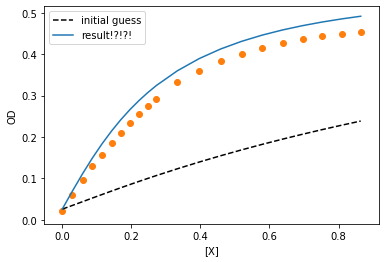

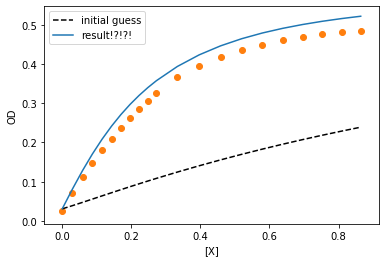

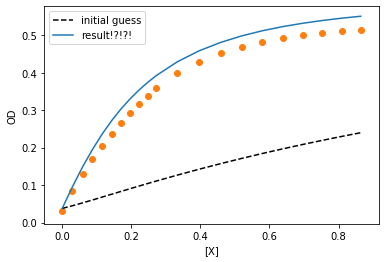

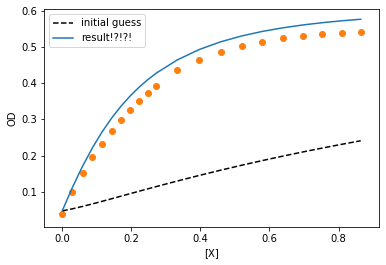

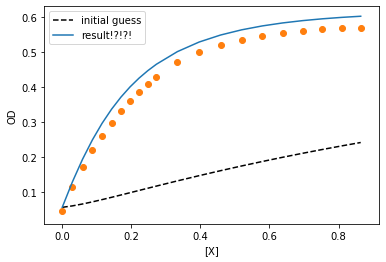

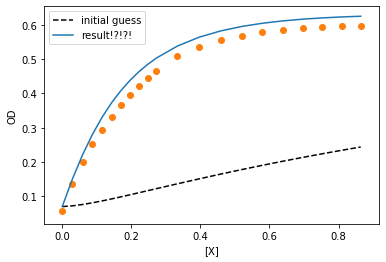

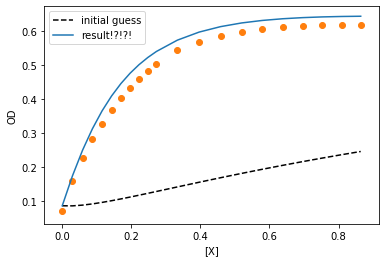

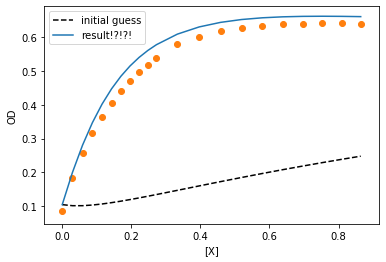

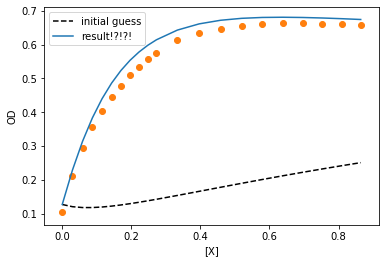

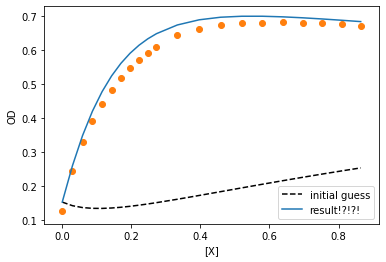

In [128]:
for i in range(19):
    plt.figure()
    ## Plot initial guess
    plt.plot(
        con_X, 
        Absorbance_per_wavelength(dummy_ini_guesses, test_data, eps_N_vec)[i], 
        ls='--',
        c='k',
        label='initial guess')

    plt.plot(con_X, Absorbance_per_wavelength(fit_multi.x, test_data, eps_N_vec)[i], label='result!?!?!')

    plt.xlabel('[X]')
    plt.ylabel('OD')
    plt.scatter(con_X, test_data.T[i,:], c='C1')
#     plt.title('380 nm')
    plt.legend()

# plt.figure()
# ## Plot initial guess
# plt.plot(
#     con_X, 
#     Absorbance_per_wavelength(ini_guess_multi)[1], 
#     ls='--',
#     c='k',
#     label='initial guess')

# plt.plot(con_X, Absorbance_per_wavelength(fit_multi.x)[1], label='result!?!?!')

# plt.xlabel('[X]')
# plt.ylabel('OD')
# plt.scatter(con_X, od_400, c='C1')
# plt.title('400 nm')
# plt.legend()

# plt.figure()
# ## Plot initial guess
# plt.plot(
#     con_X, 
#     Absorbance_per_wavelength(ini_guess_multi)[2], 
#     ls='--',
#     c='k',
#     label='initial guess')

# plt.plot(con_X, Absorbance_per_wavelength(fit_multi.x)[2], label='result!?!?!')

# plt.xlabel('[X]')
# plt.ylabel('OD')
# plt.scatter(con_X, od_365, c='C1')
# plt.title('365 nm')
# plt.legend()
